## Imports

In [1]:
from google.colab import drive
from google.colab import files
from datetime import datetime, date, timedelta

import seaborn as sns
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Yahoo dataset

In [2]:
btc_data = yf.download("BTC-USD", start="2017-01-01", end="2024-05-17")
btc_data = btc_data.reset_index()
btc_data.drop(columns=['Adj Close', 'Volume'], axis=1, inplace=True)
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data = btc_data.rename(columns={'High': 'High_BTC', 'Low': 'Low_BTC', 'Open': 'Open_BTC', 'Close': 'Close_BTC'})


eth_data = yf.download("ETH-USD", start="2017-01-01", end="2024-05-17")
eth_data = eth_data.reset_index()
eth_data.drop(columns=['Adj Close', 'Volume'], axis=1, inplace=True)
eth_data['Date'] = pd.to_datetime(eth_data['Date'])
eth_data = eth_data.rename(columns={'High': 'High_ETH', 'Low': 'Low_ETH', 'Open': 'Open_ETH', 'Close': 'Close_ETH'})


us_dxy_data = yf.download("DX-Y.NYB", start="2017-01-01", end="2024-05-17")
us_dxy_data = us_dxy_data.reset_index()
us_dxy_data.drop(columns=['Adj Close', 'Volume'], axis=1, inplace=True)
us_dxy_data['Date'] = pd.to_datetime(us_dxy_data['Date'])
us_dxy_data = us_dxy_data.rename(columns={'High': 'High_US-DXY', 'Low': 'Low_US-DXY', 'Open': 'Open_US-DXY', 'Close': 'Close_US-DXY'})


sp500_data = yf.download("^GSPC", start="2017-01-01", end="2024-05-17")
sp500_data = sp500_data.reset_index()
sp500_data.drop(columns=['Adj Close', 'Volume'], axis=1, inplace=True)
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data = sp500_data.rename(columns={'High': 'High_SP500', 'Low': 'Low_SP500', 'Open': 'Open_SP500', 'Close': 'Close_SP500'})


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Check data set frames

In [3]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2693 entries, 0 to 2692
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2693 non-null   datetime64[ns]
 1   Open_BTC   2693 non-null   float64       
 2   High_BTC   2693 non-null   float64       
 3   Low_BTC    2693 non-null   float64       
 4   Close_BTC  2693 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 105.3 KB


In [4]:
btc_data.head()

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005


In [5]:
btc_data.shape

(2693, 5)

In [6]:
eth_data.shape

(2381, 5)

In [7]:
us_dxy_data.shape

(1855, 5)

In [8]:
sp500_data.shape

(1855, 5)

## ETH is missing some data got it from Market watch in .csv

In [9]:
eth_URL= "/content/drive/MyDrive/Code/Fall 2023 code/ETHUSD.csv"

drive.mount('/content/drive', force_remount=True)
eth_missing = pd.read_csv(eth_URL,header=0, skiprows=[1])
eth_missing.shape

Mounted at /content/drive


(310, 5)

In [10]:
eth_missing.head()

,Date,Open,High,Low,Close
0,11/07/2017,298.50,303.30,287.28,292.07
1,11/06/2017,294.62,304.21,291.30,298.50
2,11/05/2017,299.10,300.57,293.01,294.62
3,11/04/2017,304.32,305.00,294.00,299.41
4,11/03/2017,283.38,309.00,283.38,304.17


In [11]:
eth_missing.tail()

,Date,Open,High,Low,Close
305,01/06/2017,10.20,10.50,9.50,10.16
306,01/05/2017,11.02,11.64,9.10,10.32
307,01/04/2017,9.63,11.12,9.42,11.02
308,01/03/2017,8.37,10.10,8.26,9.57
309,01/02/2017,8.20,8.48,8.10,8.40


In [12]:
eth_missing.drop(columns=['Open', 'Close'], axis=1, inplace=True)
eth_missing = eth_missing.rename(columns={'High': 'High_ETH', 'Low': 'Low_ETH'})
eth_missing['Date'] = pd.to_datetime(eth_missing['Date'])
eth_missing.columns

Index(['Date', 'High_ETH', 'Low_ETH'], dtype='object')

## fixed it and adding it our ETH data

In [13]:
eth_missing = eth_missing.iloc[::-1]
eth_data = pd.concat([eth_missing, eth_data], ignore_index=True)
eth_data.shape

(2691, 5)

In [14]:
eth_data.head()

,Date,High_ETH,Low_ETH,Open_ETH,Close_ETH
0,2017-01-02,8.48,8.10,NaN,NaN
1,2017-01-03,10.10,8.26,NaN,NaN
2,2017-01-04,11.12,9.42,NaN,NaN
3,2017-01-05,11.64,9.10,NaN,NaN
4,2017-01-06,10.50,9.50,NaN,NaN


## Merge all data sets

In [15]:
# Merge dataframes date-wise
merged_data = pd.merge(btc_data, eth_data, on='Date', how='outer')
merged_data = pd.merge(merged_data, us_dxy_data, on='Date', how='outer')
merged_data = pd.merge(merged_data, sp500_data, on='Date', how='outer')

merged_data.head()

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,High_ETH,Low_ETH,Open_ETH,Close_ETH,Open_US-DXY,High_US-DXY,Low_US-DXY,Close_US-DXY,Open_SP500,High_SP500,Low_SP500,Close_SP500
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,8.48,8.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,10.10,8.26,NaN,NaN,102.870003,103.820000,102.589996,103.209999,2251.570068,2263.879883,2245.129883,2257.830078
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,11.12,9.42,NaN,NaN,103.180000,103.440002,102.389999,102.699997,2261.600098,2272.820068,2261.600098,2270.750000
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,11.64,9.10,NaN,NaN,102.430000,102.510002,101.300003,101.519997,2268.179932,2271.500000,2260.449951,2269.000000


In [16]:
merged_data.shape

(2693, 17)

## Fill it forward and backward where need to avoid Nulls

In [17]:
merged_data.iloc[:5] = merged_data.iloc[:5].fillna(method='ffill')
merged_data = merged_data.fillna(method='bfill')
merged_data.iloc[-5:] = merged_data.iloc[-5:].fillna(method='ffill')

In [18]:
merged_data.head()

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,High_ETH,Low_ETH,Open_ETH,Close_ETH,Open_US-DXY,High_US-DXY,Low_US-DXY,Close_US-DXY,Open_SP500,High_SP500,Low_SP500,Close_SP500
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,8.48,8.10,308.644989,320.884003,102.870003,103.820000,102.589996,103.209999,2251.570068,2263.879883,2245.129883,2257.830078
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,8.48,8.10,308.644989,320.884003,102.870003,103.820000,102.589996,103.209999,2251.570068,2263.879883,2245.129883,2257.830078
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,10.10,8.26,308.644989,320.884003,102.870003,103.820000,102.589996,103.209999,2251.570068,2263.879883,2245.129883,2257.830078
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,11.12,9.42,308.644989,320.884003,103.180000,103.440002,102.389999,102.699997,2261.600098,2272.820068,2261.600098,2270.750000
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,11.64,9.10,308.644989,320.884003,102.430000,102.510002,101.300003,101.519997,2268.179932,2271.500000,2260.449951,2269.000000


In [19]:
merged_data.tail()

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,High_ETH,Low_ETH,Open_ETH,Close_ETH,Open_US-DXY,High_US-DXY,Low_US-DXY,Close_US-DXY,Open_SP500,High_SP500,Low_SP500,Close_SP500
2688,2024-05-12,60793.503906,61818.156250,60632.601562,61448.394531,2953.047363,2902.201904,2911.658203,2928.701904,105.309998,105.370003,105.059998,105.220001,5233.080078,5237.259766,5211.160156,5221.419922
2689,2024-05-13,61451.218750,63422.660156,60769.839844,62901.449219,2994.869141,2865.134521,2928.813965,2949.359619,105.309998,105.370003,105.059998,105.220001,5233.080078,5237.259766,5211.160156,5221.419922
2690,2024-05-14,62900.773438,63092.125000,61123.765625,61552.789062,2959.546631,2863.545898,2949.213135,2881.157959,105.199997,105.459999,104.959999,105.010002,5221.100098,5250.370117,5217.979980,5246.680176
2691,2024-05-15,61553.988281,66454.453125,61330.410156,66267.492188,3041.602295,2864.735352,2881.224609,3037.056641,105.050003,105.059998,104.290001,104.349998,5263.259766,5311.759766,5263.259766,5308.149902
2692,2024-05-16,66256.109375,66712.429688,64613.054688,65231.582031,3041.807129,2925.087402,3036.014160,2945.131104,104.209999,104.629997,104.080002,104.459999,5310.069824,5325.490234,5296.189941,5297.100098


## Download it for backup

In [20]:
merged_data.to_csv('merged_data.csv')
files.download('merged_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
merged_data.shape

(2693, 17)

In [22]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2693 entries, 0 to 2692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2693 non-null   datetime64[ns]
 1   Open_BTC      2693 non-null   float64       
 2   High_BTC      2693 non-null   float64       
 3   Low_BTC       2693 non-null   float64       
 4   Close_BTC     2693 non-null   float64       
 5   High_ETH      2693 non-null   float64       
 6   Low_ETH       2693 non-null   float64       
 7   Open_ETH      2693 non-null   float64       
 8   Close_ETH     2693 non-null   float64       
 9   Open_US-DXY   2693 non-null   float64       
 10  High_US-DXY   2693 non-null   float64       
 11  Low_US-DXY    2693 non-null   float64       
 12  Close_US-DXY  2693 non-null   float64       
 13  Open_SP500    2693 non-null   float64       
 14  High_SP500    2693 non-null   float64       
 15  Low_SP500     2693 non-null   float64 

In [23]:
merged_data.isna().sum()

Date            0
Open_BTC        0
High_BTC        0
Low_BTC         0
Close_BTC       0
High_ETH        0
Low_ETH         0
Open_ETH        0
Close_ETH       0
Open_US-DXY     0
High_US-DXY     0
Low_US-DXY      0
Close_US-DXY    0
Open_SP500      0
High_SP500      0
Low_SP500       0
Close_SP500     0
dtype: int64

## Data exploration and visualization

In [24]:
merged_data.describe()

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,High_ETH,Low_ETH,Open_ETH,Close_ETH,Open_US-DXY,High_US-DXY,Low_US-DXY,Close_US-DXY,Open_SP500,High_SP500,Low_SP500,Close_SP500
count,2693,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000
mean,2020-09-08 00:00:00,21137.553528,21631.279512,20609.455068,21159.805991,1237.397852,1165.294402,1219.286126,1221.512203,97.937029,98.235414,97.662525,97.953832,3507.179723,3525.946808,3486.856178,3507.727406
min,2017-01-01 00:00:00,775.177979,823.307007,755.755981,777.757019,8.480000,8.100000,84.279694,84.308296,88.570000,89.000000,88.250000,88.589996,2251.570068,2263.879883,2191.860107,2237.399902
25%,2018-11-05 00:00:00,7062.939941,7269.956543,6863.520020,7078.500000,226.604004,210.437912,281.967987,281.944000,93.720001,93.980003,93.470001,93.699997,2773.939941,2784.000000,2752.780029,2770.370117
50%,2020-09-08 00:00:00,12571.537109,13145.066406,11833.000000,12823.689453,702.783997,644.065979,683.205811,683.677979,97.199997,97.440002,97.000000,97.220001,3369.820068,3387.590088,3355.610107,3373.939941
75%,2022-07-13 00:00:00,32985.757812,34222.074219,31493.160156,33086.234375,1911.608643,1847.850708,1874.560425,1876.059692,102.059998,102.449997,101.730003,102.099998,4222.580078,4238.040039,4192.180176,4210.240234
max,2024-05-16 00:00:00,73079.375000,73750.070312,71334.093750,73083.500000,4891.704590,4718.039062,4810.071289,4812.087402,114.190002,114.779999,113.330002,114.110001,5310.069824,5325.490234,5296.189941,5308.149902
std,NaN,17961.845846,18391.037923,17483.266856,17975.041485,1191.966451,1123.383268,1145.352434,1144.238814,5.193413,5.257719,5.135431,5.205628,818.209271,822.551358,814.136128,818.787047


<Axes: >

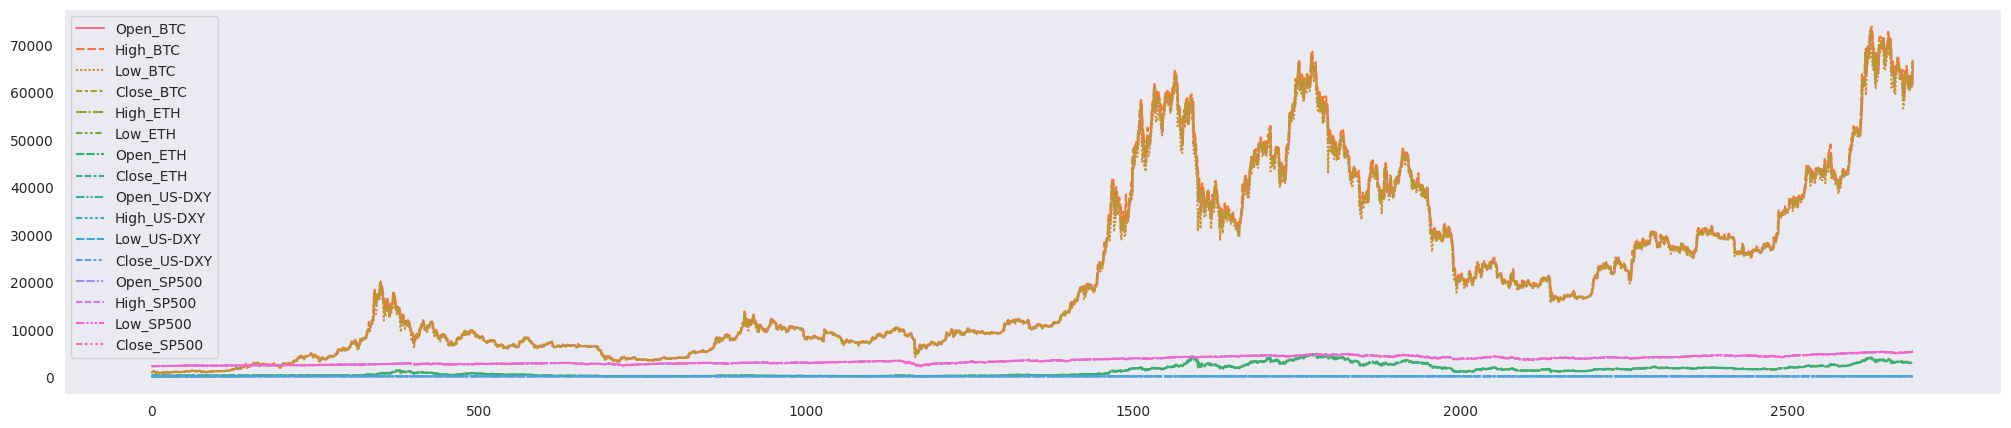

In [25]:
plt.figure(figsize = (25, 5))
sns.set_style('dark')
sns.lineplot(data=merged_data)

In [26]:
line_chart = go.Scatter(
    x=merged_data['Date'],
    y=merged_data['Open_BTC'],
    mode='lines',
    name='BTC Prices'
)

# Create figure and add line chart
fig = go.Figure(data=[line_chart])

# Customize layout
fig.update_layout(
    title='BTC Price Trend',
    xaxis_title='Date',
    yaxis_title='Price (USD)'
)

# Show the figure
fig.show()

# Correlation of data

In [27]:
merged_data.corr()

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,High_ETH,Low_ETH,Open_ETH,Close_ETH,Open_US-DXY,High_US-DXY,Low_US-DXY,Close_US-DXY,Open_SP500,High_SP500,Low_SP500,Close_SP500
Date,1.000000,0.735182,0.731532,0.740844,0.735462,0.705723,0.716545,0.696098,0.695289,0.564286,0.564340,0.566751,0.565968,0.926411,0.928684,0.924348,0.926532
Open_BTC,0.735182,1.000000,0.999367,0.998923,0.998528,0.935615,0.934596,0.931539,0.931385,0.113752,0.113046,0.118401,0.116240,0.897008,0.896532,0.897083,0.896611
High_BTC,0.731532,0.999367,1.000000,0.998748,0.999362,0.934639,0.933146,0.929672,0.930687,0.107662,0.106884,0.112142,0.109931,0.894430,0.894033,0.894575,0.894141
Low_BTC,0.740844,0.998923,0.998748,1.000000,0.999231,0.935436,0.936351,0.931029,0.932671,0.122455,0.121520,0.127063,0.124690,0.900636,0.900216,0.900926,0.900456
Close_BTC,0.735462,0.998528,0.999362,0.999231,1.000000,0.933727,0.933507,0.928623,0.931098,0.113542,0.112607,0.118008,0.115618,0.896808,0.896500,0.897174,0.896816
High_ETH,0.705723,0.935615,0.934639,0.935436,0.933727,1.000000,0.998212,0.997874,0.997509,0.151514,0.152138,0.155351,0.154530,0.881980,0.881706,0.881206,0.881118
Low_ETH,0.716545,0.934596,0.933146,0.936351,0.933507,0.998212,1.000000,0.997038,0.997459,0.169495,0.169969,0.173547,0.172558,0.888076,0.887779,0.887485,0.887346
Open_ETH,0.696098,0.931539,0.929672,0.931029,0.928623,0.997874,0.997038,1.000000,0.998009,0.166425,0.167096,0.170482,0.169629,0.875697,0.875223,0.874990,0.874740
Close_ETH,0.695289,0.931385,0.930687,0.932671,0.931098,0.997509,0.997459,0.998009,1.000000,0.165609,0.165978,0.169360,0.168226,0.875250,0.874954,0.874899,0.874764
Open_US-DXY,0.564286,0.113752,0.107662,0.122455,0.113542,0.151514,0.169495,0.166425,0.165609,1.000000,0.998725,0.998823,0.997183,0.351008,0.353972,0.349170,0.351522


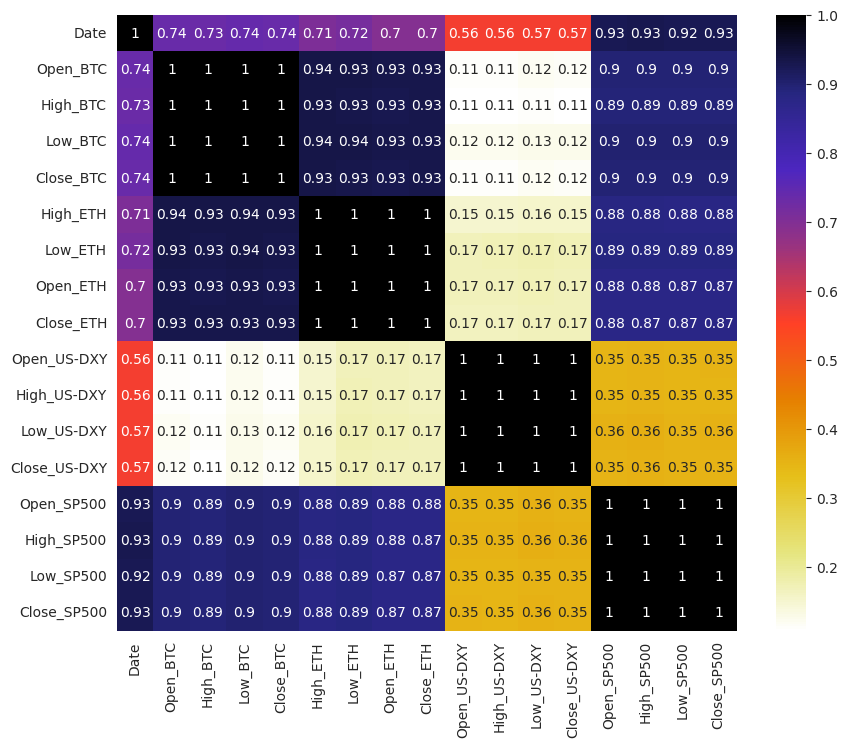

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(merged_data.corr(), annot=True, cmap=plt.cm.CMRmap_r);

## Restart from here get the backupfile

In [29]:
merged_data_URl= "/content/drive/MyDrive/Code/Fall 2023 code/merged_data(new).csv"

drive.mount('/content/drive', force_remount=True)
merged_data = pd.read_csv(merged_data_URl,header=0, skiprows=[1])
merged_data.drop(columns=['Unnamed: 0'], inplace=True)
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data.shape

Mounted at /content/drive


(2692, 17)

In [30]:
merged_data.head()

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,High_ETH,Low_ETH,Open_ETH,Close_ETH,Open_US-DXY,High_US-DXY,Low_US-DXY,Close_US-DXY,Open_SP500,High_SP500,Low_SP500,Close_SP500
0,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,8.48,8.10,308.644989,320.884003,102.870003,103.820000,102.589996,103.209999,2251.570068,2263.879883,2245.129883,2257.830078
1,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,10.10,8.26,308.644989,320.884003,102.870003,103.820000,102.589996,103.209999,2251.570068,2263.879883,2245.129883,2257.830078
2,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,11.12,9.42,308.644989,320.884003,103.180000,103.440002,102.389999,102.699997,2261.600098,2272.820068,2261.600098,2270.750000
3,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,11.64,9.10,308.644989,320.884003,102.430000,102.510002,101.300003,101.519997,2268.179932,2271.500000,2260.449951,2269.000000
4,2017-01-06,1014.239990,1046.810059,883.943970,902.200989,10.50,9.50,308.644989,320.884003,101.419998,102.290001,101.370003,102.220001,2271.139893,2282.100098,2264.060059,2276.979980


## Calculation of moving average(MA) and RSI

In [31]:
# Calculate daily gains
merged_data['Gain'] = merged_data['High_BTC'] - merged_data['Low_BTC']

# Calculate daily changes
merged_data['Change'] = merged_data['Gain'].diff()

# Separate gains and losses into two separate columns
merged_data['Gain'] = merged_data['Change'].apply(lambda x: x if x > 0 else 0)
merged_data['Loss'] = merged_data['Change'].apply(lambda x: abs(x) if x < 0 else 0)

# Calculate the average gains and losses over a specific period (e.g., 14 days)
period = 14
merged_data['Average Gain'] = merged_data['Gain'].rolling(window=period).mean()
merged_data['Average Loss'] = merged_data['Loss'].rolling(window=period).mean()

# Calculate Relative Strength (RS)
merged_data['RS'] = merged_data['Average Gain'] / merged_data['Average Loss']

# Calculate Relative Strength Index (RSI)
merged_data['RSI'] = 100 - (100 / (1 + merged_data['RS']))


In [32]:
merged_data

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,High_ETH,Low_ETH,Open_ETH,Close_ETH,Open_US-DXY,...,High_SP500,Low_SP500,Close_SP500,Gain,Change,Loss,Average Gain,Average Loss,RS,RSI
0,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,8.480000,8.100000,308.644989,320.884003,102.870003,...,2263.879883,2245.129883,2257.830078,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
1,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,10.100000,8.260000,308.644989,320.884003,102.870003,...,2263.879883,2245.129883,2257.830078,0.000000,-12.208008,12.208008,NaN,NaN,NaN,NaN
2,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,11.120000,9.420000,308.644989,320.884003,103.180000,...,2272.820068,2261.600098,2270.750000,92.540039,92.540039,0.000000,NaN,NaN,NaN,NaN
3,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,11.640000,9.100000,308.644989,320.884003,102.430000,...,2271.500000,2260.449951,2269.000000,165.662964,165.662964,0.000000,NaN,NaN,NaN,NaN
4,2017-01-06,1014.239990,1046.810059,883.943970,902.200989,10.500000,9.500000,308.644989,320.884003,101.419998,...,2282.100098,2264.060059,2276.979980,0.000000,-117.816895,117.816895,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,2024-05-12,60793.503906,61818.156250,60632.601562,61448.394531,2953.047363,2902.201904,2911.658203,2928.701904,105.309998,...,5237.259766,5211.160156,5221.419922,227.027344,227.027344,0.000000,594.004743,618.457031,0.960462,48.991626
2688,2024-05-13,61451.218750,63422.660156,60769.839844,62901.449219,2994.869141,2865.134521,2928.813965,2949.359619,105.309998,...,5237.259766,5211.160156,5221.419922,1467.265625,1467.265625,0.000000,637.985491,618.457031,1.031576,50.777133
2689,2024-05-14,62900.773438,63092.125000,61123.765625,61552.789062,2959.546631,2863.545898,2949.213135,2881.157959,105.199997,...,5250.370117,5217.979980,5246.680176,0.000000,-684.460938,684.460938,409.139509,667.347098,0.613084,38.006930
2690,2024-05-15,61553.988281,66454.453125,61330.410156,66267.492188,3041.602295,2864.735352,2881.224609,3037.056641,105.050003,...,5311.759766,5263.259766,5308.149902,3155.683594,3155.683594,0.000000,634.545480,570.342913,1.112568,52.664254


In [33]:
# Calculate the average of 'High' and 'Low' prices
merged_data['Average_Price'] = (merged_data['High_BTC'] + merged_data['Low_BTC']) / 2

# Calculate the 7-day moving average using the average price
merged_data['MA7_Average'] = merged_data['Average_Price'].rolling(window=7).mean()

merged_data

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,High_ETH,Low_ETH,Open_ETH,Close_ETH,Open_US-DXY,...,Close_SP500,Gain,Change,Loss,Average Gain,Average Loss,RS,RSI,Average_Price,MA7_Average
0,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,8.480000,8.100000,308.644989,320.884003,102.870003,...,2257.830078,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,1014.046021,NaN
1,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,10.100000,8.260000,308.644989,320.884003,102.870003,...,2257.830078,0.000000,-12.208008,12.208008,NaN,NaN,NaN,NaN,1032.839966,NaN
2,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,11.120000,9.420000,308.644989,320.884003,103.180000,...,2270.750000,92.540039,92.540039,0.000000,NaN,NaN,NaN,NaN,1101.910034,NaN
3,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,11.640000,9.100000,308.644989,320.884003,102.430000,...,2269.000000,165.662964,165.662964,0.000000,NaN,NaN,NaN,NaN,1050.758484,NaN
4,2017-01-06,1014.239990,1046.810059,883.943970,902.200989,10.500000,9.500000,308.644989,320.884003,101.419998,...,2276.979980,0.000000,-117.816895,117.816895,NaN,NaN,NaN,NaN,965.377014,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,2024-05-12,60793.503906,61818.156250,60632.601562,61448.394531,2953.047363,2902.201904,2911.658203,2928.701904,105.309998,...,5221.419922,227.027344,227.027344,0.000000,594.004743,618.457031,0.960462,48.991626,61225.378906,62205.988560
2688,2024-05-13,61451.218750,63422.660156,60769.839844,62901.449219,2994.869141,2865.134521,2928.813965,2949.359619,105.309998,...,5221.419922,1467.265625,1467.265625,0.000000,637.985491,618.457031,1.031576,50.777133,62096.250000,61916.799944
2689,2024-05-14,62900.773438,63092.125000,61123.765625,61552.789062,2959.546631,2863.545898,2949.213135,2881.157959,105.199997,...,5246.680176,0.000000,-684.460938,684.460938,409.139509,667.347098,0.613084,38.006930,62107.945312,61741.046596
2690,2024-05-15,61553.988281,66454.453125,61330.410156,66267.492188,3041.602295,2864.735352,2881.224609,3037.056641,105.050003,...,5308.149902,3155.683594,3155.683594,0.000000,634.545480,570.342913,1.112568,52.664254,63892.431641,62021.164342


In [34]:
merged_data.corr()

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,High_ETH,Low_ETH,Open_ETH,Close_ETH,Open_US-DXY,...,Close_SP500,Gain,Change,Loss,Average Gain,Average Loss,RS,RSI,Average_Price,MA7_Average
Date,1.000000,0.735042,0.731388,0.740708,0.735322,0.705592,0.716423,0.696056,0.695250,0.565307,...,0.926467,0.209062,0.000059,0.216839,0.489977,0.498196,-0.016539,-0.003377,0.736161,0.735729
Open_BTC,0.735042,1.000000,0.999367,0.998923,0.998528,0.935589,0.934569,0.931535,0.931383,0.114195,...,0.896572,0.359422,0.005391,0.364565,0.826126,0.835885,-0.011823,0.011183,0.999463,0.998009
High_BTC,0.731388,0.999367,1.000000,0.998748,0.999362,0.934612,0.933119,0.929667,0.930684,0.108102,...,0.894101,0.370027,0.013806,0.362479,0.831244,0.838385,-0.003098,0.019761,0.999703,0.997633
Low_BTC,0.740708,0.998923,0.998748,1.000000,0.999230,0.935409,0.936325,0.931024,0.932668,0.122901,...,0.900420,0.335330,-0.013357,0.368729,0.814670,0.830254,-0.023460,-0.000195,0.999671,0.996876
Close_BTC,0.735322,0.998528,0.999362,0.999230,1.000000,0.933700,0.933480,0.928618,0.931094,0.113983,...,0.896777,0.353458,0.000528,0.365941,0.823504,0.834360,-0.012012,0.011079,0.999611,0.996794
High_ETH,0.705592,0.935589,0.934612,0.935409,0.933700,1.000000,0.998211,0.997884,0.997519,0.151933,...,0.881089,0.342038,0.011022,0.337767,0.777882,0.790970,-0.023224,0.000030,0.935293,0.938213
Low_ETH,0.716423,0.934569,0.933119,0.936325,0.933480,0.998211,1.000000,0.997048,0.997469,0.169921,...,0.887321,0.310615,-0.011007,0.339430,0.757870,0.778028,-0.038349,-0.015313,0.934974,0.936451
Open_ETH,0.696056,0.931535,0.929667,0.931024,0.928618,0.997884,0.997048,1.000000,0.998008,0.166753,...,0.874771,0.336973,0.010178,0.333822,0.768985,0.783220,-0.026216,-0.003106,0.930620,0.933873
Close_ETH,0.695250,0.931383,0.930684,0.932668,0.931094,0.997519,0.997469,0.998008,1.000000,0.165934,...,0.874797,0.322749,-0.003437,0.340245,0.766893,0.783906,-0.030112,-0.006708,0.931943,0.933954
Open_US-DXY,0.565307,0.114195,0.108102,0.122901,0.113983,0.151933,0.169921,0.166753,0.165934,1.000000,...,0.352272,-0.036251,-0.002301,-0.034036,-0.073459,-0.071391,-0.015148,-0.008173,0.115350,0.119951


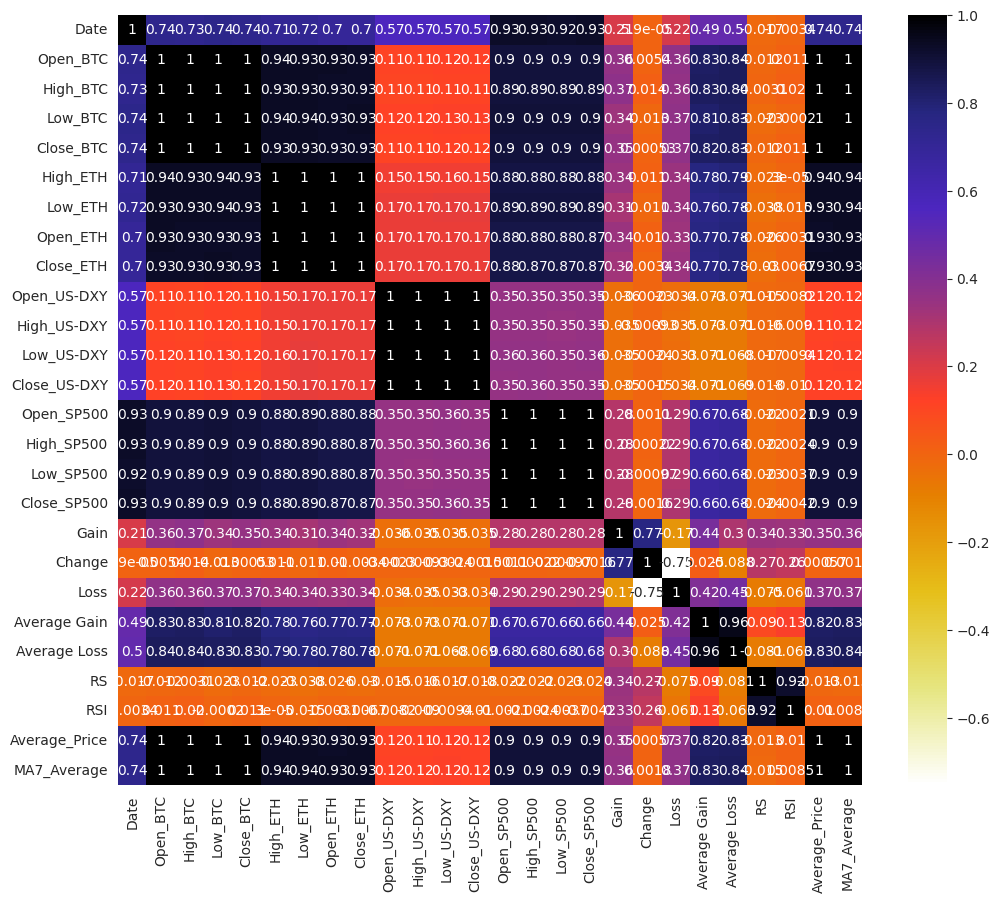

In [35]:
plt.figure(figsize=(12,10))
sns.heatmap(merged_data.corr(), annot=True, cmap=plt.cm.CMRmap_r);

In [36]:
merged_data.drop(columns=['High_US-DXY', 'Low_US-DXY','Close_US-DXY', 'Open_US-DXY',], axis=1, inplace=True)

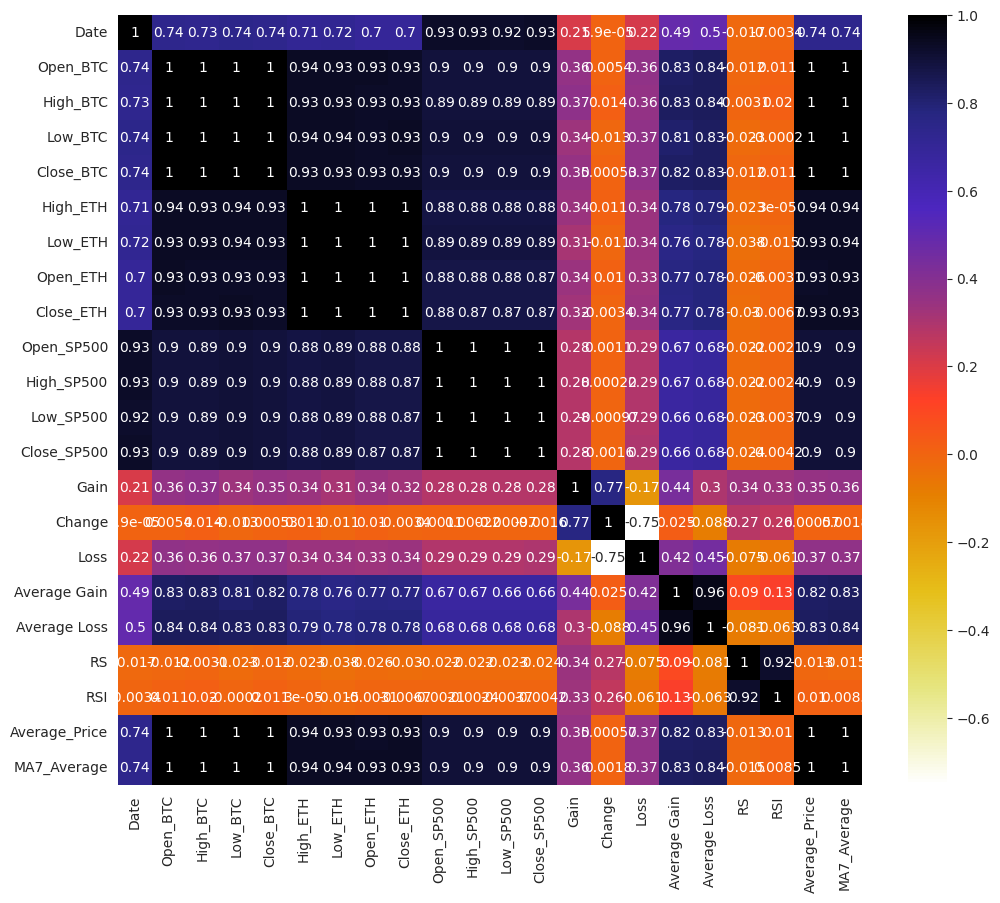

In [37]:
plt.figure(figsize=(12,10))
sns.heatmap(merged_data.corr(), annot=True, cmap=plt.cm.CMRmap_r);

In [38]:
merged_data.drop(columns=['Gain', 'Change', 'Loss'], axis=1, inplace=True)

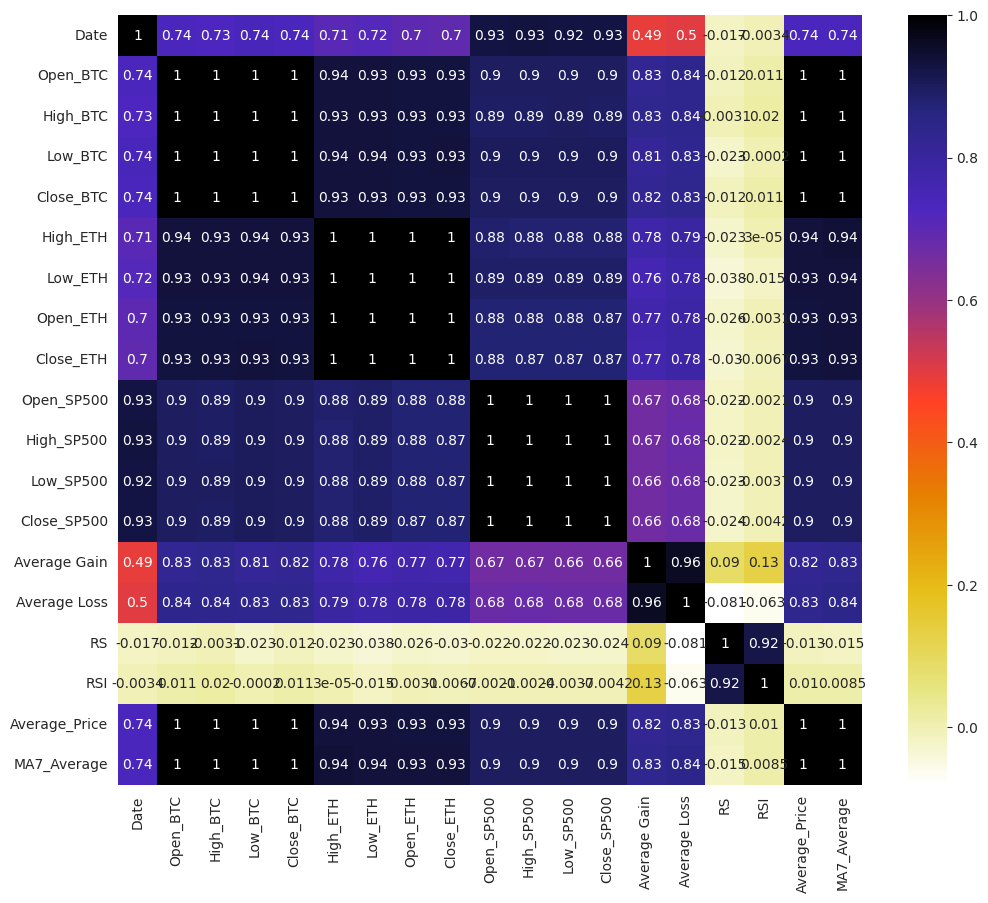

In [39]:
plt.figure(figsize=(12,10))
sns.heatmap(merged_data.corr(), annot=True, cmap=plt.cm.CMRmap_r);

In [40]:
merged_data.drop(columns=['RS', 'RSI'], axis=1, inplace=True)

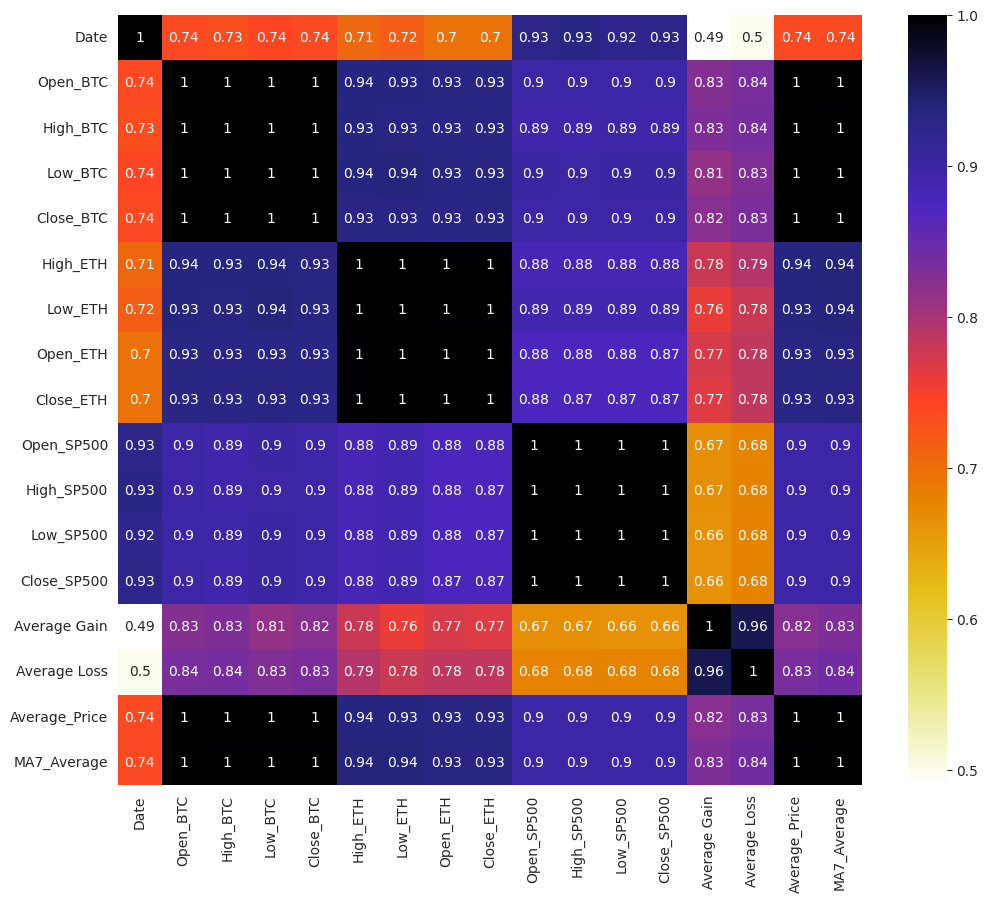

In [41]:
plt.figure(figsize=(12,10))
sns.heatmap(merged_data.corr(), annot=True, cmap=plt.cm.CMRmap_r);

In [42]:
merged_data.drop(columns=['Average Gain', 'Average Loss'], axis=1, inplace=True)

In [43]:
merged_data

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,High_ETH,Low_ETH,Open_ETH,Close_ETH,Open_SP500,High_SP500,Low_SP500,Close_SP500,Average_Price,MA7_Average
0,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,8.480000,8.100000,308.644989,320.884003,2251.570068,2263.879883,2245.129883,2257.830078,1014.046021,NaN
1,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,10.100000,8.260000,308.644989,320.884003,2251.570068,2263.879883,2245.129883,2257.830078,1032.839966,NaN
2,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,11.120000,9.420000,308.644989,320.884003,2261.600098,2272.820068,2261.600098,2270.750000,1101.910034,NaN
3,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,11.640000,9.100000,308.644989,320.884003,2268.179932,2271.500000,2260.449951,2269.000000,1050.758484,NaN
4,2017-01-06,1014.239990,1046.810059,883.943970,902.200989,10.500000,9.500000,308.644989,320.884003,2271.139893,2282.100098,2264.060059,2276.979980,965.377014,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,2024-05-12,60793.503906,61818.156250,60632.601562,61448.394531,2953.047363,2902.201904,2911.658203,2928.701904,5233.080078,5237.259766,5211.160156,5221.419922,61225.378906,62205.988560
2688,2024-05-13,61451.218750,63422.660156,60769.839844,62901.449219,2994.869141,2865.134521,2928.813965,2949.359619,5233.080078,5237.259766,5211.160156,5221.419922,62096.250000,61916.799944
2689,2024-05-14,62900.773438,63092.125000,61123.765625,61552.789062,2959.546631,2863.545898,2949.213135,2881.157959,5221.100098,5250.370117,5217.979980,5246.680176,62107.945312,61741.046596
2690,2024-05-15,61553.988281,66454.453125,61330.410156,66267.492188,3041.602295,2864.735352,2881.224609,3037.056641,5263.259766,5311.759766,5263.259766,5308.149902,63892.431641,62021.164342


In [44]:
merged_data.drop(index=merged_data.index[:13], inplace=True)

# Reset the index after dropping rows
merged_data.reset_index(drop=True, inplace=True)

In [45]:
merged_data.corr()

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,High_ETH,Low_ETH,Open_ETH,Close_ETH,Open_SP500,High_SP500,Low_SP500,Close_SP500,Average_Price,MA7_Average
Date,1.000000,0.733173,0.729487,0.738882,0.733452,0.703871,0.714810,0.695495,0.694728,0.925498,0.927791,0.923423,0.925625,0.734297,0.734719
Open_BTC,0.733173,1.000000,0.999363,0.998916,0.998519,0.935245,0.934220,0.931484,0.931346,0.896449,0.895976,0.896513,0.896044,0.999460,0.998002
High_BTC,0.729487,0.999363,1.000000,0.998740,0.999358,0.934263,0.932762,0.929607,0.930643,0.893849,0.893457,0.893984,0.893554,0.999701,0.997625
Low_BTC,0.738882,0.998916,0.998740,1.000000,0.999226,0.935065,0.935987,0.930976,0.932643,0.900101,0.899686,0.900381,0.899916,0.999669,0.996866
Close_BTC,0.733452,0.998519,0.999358,0.999226,1.000000,0.933346,0.933125,0.928555,0.931059,0.896244,0.895942,0.896602,0.896248,0.999608,0.996783
High_ETH,0.703871,0.935245,0.934263,0.935065,0.933346,1.000000,0.998202,0.998010,0.997653,0.881565,0.881300,0.880768,0.880691,0.934948,0.938035
Low_ETH,0.714810,0.934220,0.932762,0.935987,0.933125,0.998202,1.000000,0.997169,0.997602,0.887717,0.887428,0.887104,0.886975,0.934628,0.936269
Open_ETH,0.695495,0.931484,0.929607,0.930976,0.928555,0.998010,0.997169,1.000000,0.998003,0.876117,0.875659,0.875377,0.875145,0.930567,0.933854
Close_ETH,0.694728,0.931346,0.930643,0.932643,0.931059,0.997653,0.997602,0.998003,1.000000,0.875701,0.875422,0.875319,0.875204,0.931911,0.933943
Open_SP500,0.925498,0.896449,0.893849,0.900101,0.896244,0.881565,0.887717,0.876117,0.875701,1.000000,0.999728,0.999569,0.999288,0.897179,0.898037


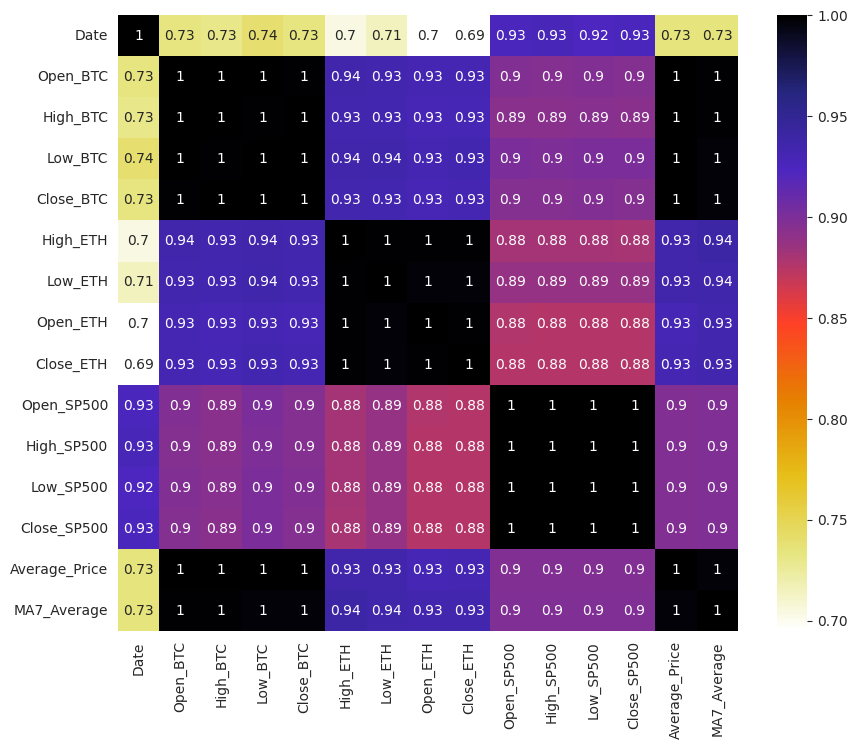

In [46]:
plt.figure(figsize=(10,8))
sns.heatmap(merged_data.corr(), annot=True, cmap=plt.cm.CMRmap_r);

In [47]:
merged_data.columns

Index(['Date', 'Open_BTC', 'High_BTC', 'Low_BTC', 'Close_BTC', 'High_ETH',
       'Low_ETH', 'Open_ETH', 'Close_ETH', 'Open_SP500', 'High_SP500',
       'Low_SP500', 'Close_SP500', 'Average_Price', 'MA7_Average'],
      dtype='object')

In [48]:
merged_data.head()

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,High_ETH,Low_ETH,Open_ETH,Close_ETH,Open_SP500,High_SP500,Low_SP500,Close_SP500,Average_Price,MA7_Average
0,2017-01-15,818.142029,823.307007,812.870972,821.797974,9.88,9.66,308.644989,320.884003,2269.139893,2272.080078,2262.810059,2267.889893,818.088989,840.454564
1,2017-01-16,821.783020,834.530029,820.270996,831.533997,9.87,9.59,308.644989,320.884003,2269.139893,2272.080078,2262.810059,2267.889893,827.400513,830.547995
2,2017-01-17,830.945984,910.560974,830.796021,907.937988,10.69,9.61,308.644989,320.884003,2269.139893,2272.080078,2262.810059,2267.889893,870.678497,825.221139
3,2017-01-18,909.372986,917.499023,858.304016,886.617981,10.50,9.90,308.644989,320.884003,2269.139893,2272.010010,2263.350098,2271.889893,887.901520,831.906141
4,2017-01-19,888.335022,904.614014,884.338013,899.072998,10.60,10.20,308.644989,320.884003,2271.899902,2274.330078,2258.409912,2263.689941,894.476013,846.688289


merged_data.set_index('Date', inplace=True)

# LSTM Model:

In [49]:
columns_to_use = ['Open_BTC', 'High_BTC', 'Low_BTC', 'Close_BTC']
data = merged_data[columns_to_use].values

## Normalizing the data

In [50]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

## Splitting the Data

In [51]:

train_size = int(len(scaled_data) * 0.99)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

## Sequences for LSTM

In [52]:

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


## Reshaping the data

In [53]:
sequence_length = 14

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(columns_to_use)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(columns_to_use)))


## Building the LSTM

In [54]:
# Building
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], len(columns_to_use))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(columns_to_use)))
model.compile(optimizer='adam', loss='mean_squared_error')

# Training
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)


Epoch 1/25
83/83 [==============================] - 13s 26ms/step - loss: 0.0140
Epoch 2/25
83/83 [==============================] - 1s 18ms/step - loss: 0.0034
Epoch 3/25
83/83 [==============================] - 1s 16ms/step - loss: 0.0029
Epoch 4/25
83/83 [==============================] - 1s 16ms/step - loss: 0.0027
Epoch 5/25
83/83 [==============================] - 1s 16ms/step - loss: 0.0026
Epoch 6/25
83/83 [==============================] - 2s 22ms/step - loss: 0.0022
Epoch 7/25
83/83 [==============================] - 2s 24ms/step - loss: 0.0020
Epoch 8/25
83/83 [==============================] - 2s 24ms/step - loss: 0.0019
Epoch 9/25
83/83 [==============================] - 2s 19ms/step - loss: 0.0019
Epoch 10/25
83/83 [==============================] - 1s 16ms/step - loss: 0.0017
Epoch 11/25
83/83 [==============================] - 1s 16ms/step - loss: 0.0017
Epoch 12/25
83/83 [==============================] - 1s 16ms/step - loss: 0.0015
Epoch 13/25
83/83 [=================

## Visualize

In [55]:
# Predicting on test data
predictions = model.predict(X_test)

# Denormalizing the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

1/1 [==============================] - 2s 2s/step


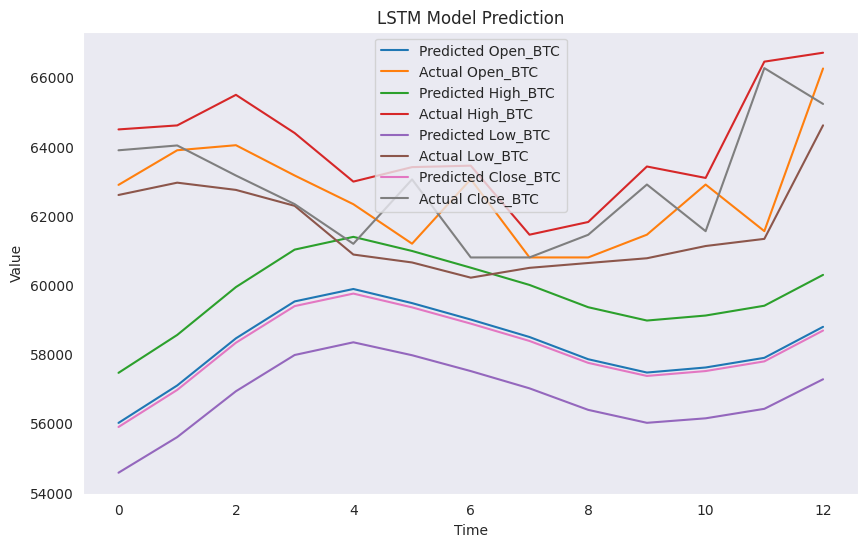

In [56]:
# Visualizing the results
plt.figure(figsize=(10, 6))
for i in range(len(columns_to_use)):
    plt.plot(predictions[:, i], label='Predicted {}'.format(columns_to_use[i]))
    plt.plot(y_test[:, i], label='Actual {}'.format(columns_to_use[i]))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('LSTM Model Prediction')
plt.legend()
plt.show()

## Predicting

In [57]:
from sklearn.metrics import mean_squared_error

# Calculating Mean Squared Error (MSE) for each feature
mse_scores = []
for i in range(len(columns_to_use)):
    mse = mean_squared_error(y_test[:, i], predictions[:, i])
    mse_scores.append(mse)
    print('Test MSE for {}: {:.6f}'.format(columns_to_use[i], mse))

# Average MSE across all features
avg_mse = np.mean(mse_scores)
print('Average Test MSE across all features: {:.6f}'.format(avg_mse))


Test MSE for Open_BTC: 22344454.242957
Test MSE for High_BTC: 21578454.384802
Test MSE for Low_BTC: 26745620.098402
Test MSE for Close_BTC: 26676159.598315
Average Test MSE across all features: 24336172.081119


In [58]:
# Preprocess input data
input_date = datetime(2024, 3, 19)
opening_value = yf.download('BTC-USD', start=input_date.strftime('%Y-%m-%d'), end=(input_date + timedelta(days=1)).strftime('%Y-%m-%d'))['Open'][0]


# Scale the input data
input_data = np.array([[opening_value] * len(columns_to_use)])
input_data = scaler.transform(input_data)

# Initialize current_data with correct shape
current_data = np.repeat(input_data, sequence_length, axis=0)
current_data = np.reshape(current_data, (1, sequence_length, len(columns_to_use)))

# Predict next 7 days
predicted_data = []
for _ in range(7):
    # Predict the next day
    next_day_prediction = model.predict(current_data)
    # Append the prediction to the list
    predicted_data.append(next_day_prediction)
    # Shift the current data for the next prediction
    current_data = np.append(current_data[:, 1:, :], next_day_prediction.reshape(1, 1, len(columns_to_use)), axis=1)

# Denormalize the predicted values
predicted_data = np.array(predicted_data).reshape((7, len(columns_to_use)))
predicted_data = scaler.inverse_transform(predicted_data)

# Create DataFrame for predicted values
predicted_df = pd.DataFrame(predicted_data, columns=['Open', 'High', 'Low', 'Close'])
predicted_df['Date'] = [input_date + timedelta(days=i) for i in range(7)]
predicted_df.set_index('Date', inplace=True)

# Print the predicted DataFrame
print(predicted_df)


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 67ms/step
                    Open          High           Low         Close
Date                                                              
2024-03-19  63196.101562  64803.773438  61688.523438  63046.285156
2024-03-20  61888.492188  63462.574219  60421.117188  61754.843750
2024-03-21  60181.453125  61721.343750  58750.886719  60055.949219
2024-03-22  58324.148438  59829.750000  56929.992188  58209.859375
2024-03-23  56450.292969  57921.257812  55093.527344  56350.917969
2024-03-24  54624.468750  56060.003906  53306.957031  54542.648438
2024-03-25  52875.382812  54274.878906  51599.007812  52812.531250


In [60]:
# Fetch the actual data using yfinance
ticker = 'BTC-USD'
start_date = input_date
end_date = input_date + timedelta(days=7)

actual_df = yf.download(ticker, start=start_date, end=end_date)

# Adjust the column names to match the predicted DataFrame
actual_df = actual_df[['Open', 'High', 'Low', 'Close']]
actual_df.index = actual_df.index.date
actual_df.index.name = 'Date'

# Print the actual DataFrame
print(actual_df)


[*********************100%%**********************]  1 of 1 completed

                    Open          High           Low         Close
Date                                                              
2024-03-19  67556.132812  68106.929688  61536.179688  61912.773438
2024-03-20  61930.156250  68115.257812  60807.785156  67913.671875
2024-03-21  67911.585938  68199.992188  64580.917969  65491.390625
2024-03-22  65489.929688  66623.750000  62355.371094  63778.761719
2024-03-23  63802.722656  65976.398438  63038.492188  64062.203125
2024-03-24  64070.753906  67622.757812  63825.851562  67234.171875
2024-03-25  67234.093750  71162.593750  66414.835938  69958.812500


In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Compute MAE
mae = mean_absolute_error(actual_df, predicted_df)

# Compute MSE
mse = mean_squared_error(actual_df, predicted_df)

# Compute RMSE
rmse = np.sqrt(mse)

# Compute MAPE
mape = np.mean(np.abs((actual_df - predicted_df) / actual_df)) * 100

# Compute R-squared
r2 = r2_score(actual_df, predicted_df)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 7468.179129464286
Mean Squared Error (MSE): 76972380.18814304
Root Mean Squared Error (RMSE): 8773.390461397637
Mean Absolute Percentage Error (MAPE): 11.222965466708475%
R-squared (R²): -20.794689016710898


In [175]:
from tensorflow.keras.models import load_model
model.save('model.h5')
